In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
from dateutil.relativedelta import relativedelta
import itertools
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

from tickers import *
from backtest_lib import *

In [2]:
print("yfinance version:", yf.__version__)

yfinance version: 0.2.66


# Abstract

We will be backtesting Ray Dalio's All-Weather Asset Allocation against the University Portfolios
* Link: https://www.optimizedportfolio.com/all-weather-portfolio/
* Link: https://andrewcharlesjones.github.io/journal/universal-portfolios.html

# Global Vars

In [3]:
DT_FORMAT = '%Y-%m-%d'

# Config

In [47]:
# LOOKUP_BACK_YR = 3
# DATE_START = (datetime.datetime.strptime(DATE_END, DT_FORMAT)  - relativedelta(years=LOOKUP_BACK_YR)).strftime(DT_FORMAT)
DATE_START = '2021-01-01'
DATE_END = ( datetime.datetime.today() + relativedelta(days=-1) ).strftime(DT_FORMAT)

# Get Data

### Pull Tickers

In [49]:
etf_tickers = [x for x in ETFS.split('\n') if len(x) > 0]
tec_tickers = [x for x in TEC_EQ.split('\n') if len(x) > 0]
fs_tickers = [x for x in FS_EQ.split('\n') if len(x) > 0]
phm_tickers = [x for x in PHM_EQ.split('\n') if len(x) > 0]

tickers = etf_tickers + tec_tickers + fs_tickers + phm_tickers

In [50]:
df_ticker = yf.download(
    ' '.join(tickers),
    start=DATE_START,
    end=DATE_END,
    auto_adjust=True,
)

[*********************100%***********************]  23 of 23 completed


In [51]:
prices = np.array(df_ticker['Close'])
returns = prices[1:]/prices[:-1]
tickers_pulled = df_ticker['Close'].columns
dates_pulled = df_ticker.index[1:]

# Visualize Returns

In [52]:
def plot_returns(dates, tickers, returns, tickers_sel, title='') -> None:

    plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
    for ticker in tickers_sel:
        ticker_index = np.where(tickers == ticker)[0][0]
        viz_cume_returns = ( np.cumprod(returns[:, ticker_index])-1 ) * 100
        plt.plot(dates, viz_cume_returns, label=ticker)
    plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle='--')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Cume Returns (%)')
    plt.title('Historical returns: ' + title)
    plt.show()

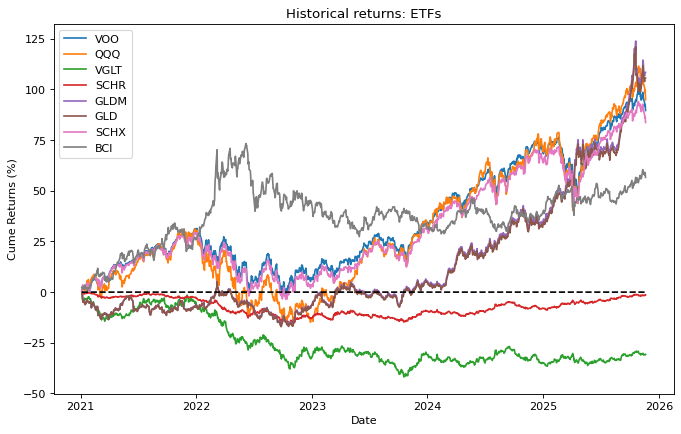

In [53]:
plot_returns(dates_pulled, tickers_pulled, returns, etf_tickers, 'ETFs')

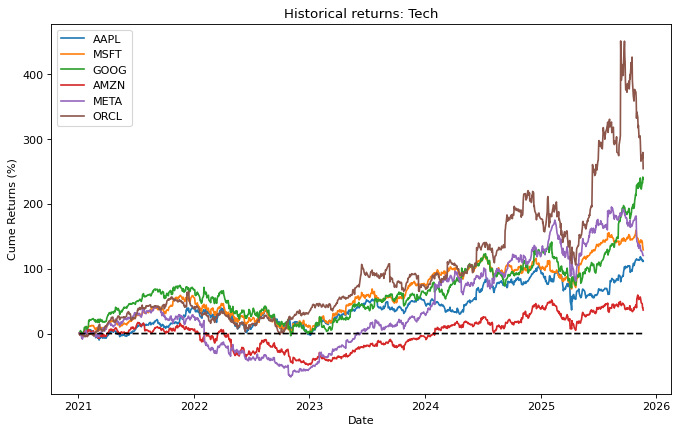

In [54]:
plot_returns(dates_pulled, tickers_pulled, returns, tec_tickers, 'Tech')

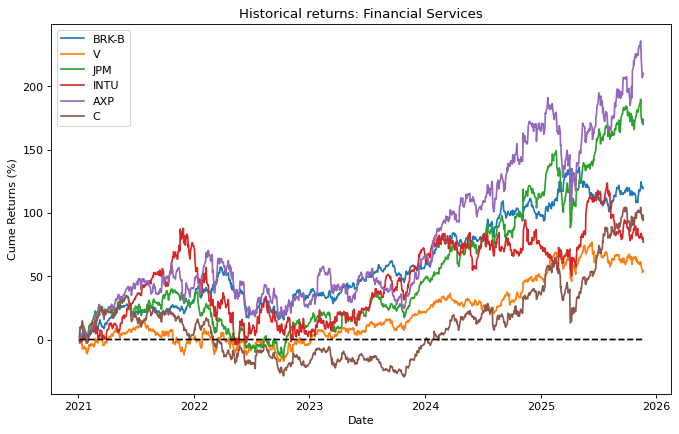

In [55]:
plot_returns(dates_pulled, tickers_pulled, returns, fs_tickers, 'Financial Services')

# Portfolio Allocation Strategy Backtest

In [56]:
n_days, n_assets = returns.shape

# generate portfolio allocations
n_portfolios = 10_000 
n_stocks_per_portfolio = 10
portfolios = []
for _ in range(n_portfolios):
    k = np.random.randint(1, n_stocks_per_portfolio)  # hold only 1-4 stocks
    w = np.zeros(n_assets)
    idx = np.random.choice(n_assets, k, replace=False)
    w[idx] = np.random.rand(k)
    w /= w.sum()
    portfolios.append(w)
portfolios = np.array(portfolios)

In [57]:
# each starting portfolio (fixed alloc) will start off with $1
wealth = np.ones(len(portfolios))

# portfolio weights / distributions at any given point in time
alloc_history = []
for t in range(n_days):

    # allocation for a given period is based on the  wealth of each portfolio eod yesterday (which has a fixed set of alloc across assets)
    alloc_t = np.average(portfolios, axis=0, weights=wealth) 

    alloc_history.append(alloc_t)

    # dot product the portfolio's wealth
    wealth *= np.dot(portfolios, returns[t]) # right hand side gives the weighted average growth of the portfolio

alloc_history = np.array(alloc_history)

In [58]:
# get cumulative returns to identify portfolio value over time
cume_returns = np.cumprod(returns, axis=0)
assert alloc_history.shape == cume_returns.shape

# for each portfolio, obtain the asset growth $
portfolio_growth = np.sum(alloc_history * cume_returns, axis=1)

df_alloc_history = pd.DataFrame(alloc_history, columns=tickers_pulled)
df_alloc_history['portfolio_growth'] = portfolio_growth
df_alloc_history['portfolio_returns'] = portfolio_growth - 1
df_alloc_history['date'] = dates_pulled

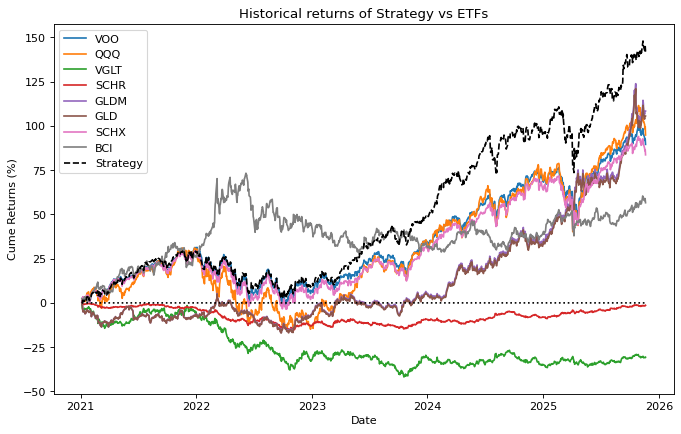

In [59]:
plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
for ticker in etf_tickers:
    ticker_index = np.where(tickers_pulled == ticker)[0][0]
    viz_cume_returns = ( np.cumprod(returns[:, ticker_index])-1 ) * 100
    plt.plot(dates_pulled, viz_cume_returns, label=ticker)
plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle=':')
plt.plot(df_alloc_history['date'], df_alloc_history['portfolio_returns']*100, label='Strategy', color='k', linestyle='--')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cume Returns (%)')
plt.title('Historical returns of Strategy vs ETFs')
plt.show()

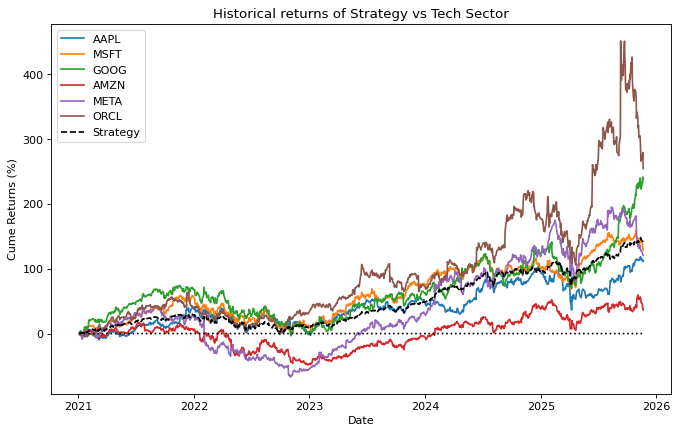

In [60]:
plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
for ticker in tec_tickers:
    ticker_index = np.where(tickers_pulled == ticker)[0][0]
    viz_cume_returns = ( np.cumprod(returns[:, ticker_index])-1 ) * 100
    plt.plot(dates_pulled, viz_cume_returns, label=ticker)
plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle=':')
plt.plot(df_alloc_history['date'], df_alloc_history['portfolio_returns']*100, label='Strategy', color='k', linestyle='--')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cume Returns (%)')
plt.title('Historical returns of Strategy vs Tech Sector')
plt.show()